# Imports and Data Ingestion

In [85]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# import the API data we already saved
round_level_data=pd.read_csv('round_data.csv')
round_level_data.drop(columns='Unnamed: 0',inplace=True)

# convert to datetime index
round_level_data['event_completed'] = pd.to_datetime(round_level_data['event_completed'])

In [87]:
# how many columns and rows do we have?:
print(f'Rows: {round_level_data.shape[0]}')
print(f'Columns: {round_level_data.shape[1]}')

Rows: 99059
Columns: 23


In [88]:
# Show the "basic" round information (used in a project visual):
round_level_data.head(5)[['round', 'dg_id', 'player_name', 'event_id', 'event_name',
       'event_completed', 'fin_text', 'score','sg_app', 'sg_arg', 'sg_ott',
       'sg_putt', 'sg_total']]

,round,dg_id,player_name,event_id,event_name,event_completed,fin_text,score,sg_app,sg_arg,sg_ott,sg_putt,sg_total
0,round_1,14139,"Thomas, Justin",16,SBS Tournament of Champions,2017-01-08,1,67,0.188,-0.908,1.479,2.584,3.344
1,round_1,13562,"Matsuyama, Hideki",16,SBS Tournament of Champions,2017-01-08,2,69,-0.267,0.340,1.143,0.127,1.344
2,round_1,14636,"Spieth, Jordan",16,SBS Tournament of Champions,2017-01-08,T3,72,1.758,-1.691,-0.471,-1.251,-1.656
3,round_1,6762,"Perez, Pat",16,SBS Tournament of Champions,2017-01-08,T3,69,1.007,0.057,0.175,0.103,1.344
4,round_1,7489,"Moore, Ryan",16,SBS Tournament of Champions,2017-01-08,T3,67,3.491,0.015,-0.349,0.186,3.344


# Player Factor Creation:

The data from DataGolf.com only has strokes gained for each round. This means we have no factors to create models for. The following code will be creating factors to measure a range of different aspects about players for the model to learn from.

**Create indicator for previous round, and previous round ONLY if it was in the same tournament.** 

This will be used to measure if previous rounds are correlated with the following (time lag). This is done by grouping by a player and tournament, then shifting back 1 round. Fill round 1 previous (which does not exist and will be NA) with a 0. 

In [89]:
# track previous round tournament, but only when the previous round was in the same tournament.
round_level_data['prev_round_tournament'] = round_level_data.groupby(['dg_id','event_id'])['sg_total'].shift(1)

In [90]:
# fill the NA value with 0
round_level_data['prev_round_tournament'].fillna(0,inplace=True)

**Create unweighted 2 year averages**

Now, create a simple measure for player strength. We will create "better" metrics for player strength later. This will just measure how well a certain player has played in the past. In turn, this will be used to measure how strong events are. 

Group by player, apply rolling mean on the [event_completed] datetime column with a window length of 730 days.
Only works on players with over 12 rounds played. The closed='left' is important so you DO NOT use the current round in
this metric. Cannot have data leakage. 

In [91]:
twoyear_unweighted = round_level_data.groupby('player_name').rolling(on='event_completed', window='730d', min_periods=12,closed='left').mean()

In [92]:
# fill NA's with -2 (average for "unknown" players)
twoyear_unweighted.fillna(-2,inplace=True)

# rename and reset index for the join
twoyear_unweighted.rename(columns={'sg_total':'two_year_avg'},inplace=True)
twoyear_unweighted.reset_index('player_name',inplace=True)

# Join back to the main dataframe
round_level_data = round_level_data.join(twoyear_unweighted['two_year_avg'])

**Create unwieghted yearly SG averages, used as a player skill breakdown beyond just
total SG averages**

This will also create a breakdown of a players skill in the last year, but in terms of their different areas of their game. For example, a player's approach game strength in the last year will be roughly measure by the ['yearly_sg_app'] factor. This is used later (especially when exploring course fit metrics). 

In [94]:
# Groupby player, apply rolling mean on the [event_completed] column, window length of 365 days.
# Only works on players with over 12 rounds played. 
oneyear_unweighted = round_level_data.groupby('player_name').rolling(on='event_completed', window='365d', min_periods=12,closed='left').mean()
# rename and reset index for the join
oneyear_unweighted = oneyear_unweighted[['sg_app','sg_arg','sg_ott','sg_putt']] 
oneyear_unweighted.rename(columns={'sg_app':'yearly_sg_app',
                                   'sg_arg':'yearly_sg_arg',
                                   'sg_ott':'yearly_sg_ott',
                                   'sg_putt':'yearly_sg_putt',
                                  },inplace=True)
oneyear_unweighted.reset_index('player_name',inplace=True)
# Join back to the main dataframe
round_level_data = round_level_data.merge(oneyear_unweighted,left_index=True,right_index=True,copy=False,suffixes=('', '_y'))

round_level_data.drop(round_level_data.filter(regex='_y$').columns, axis=1, inplace=True)


**Create Event Strength Metric (measure of how good the players in the event are)**

Using player's ['two_year_avg'], measure the strength of a certain round by taking the average of all players participating in the round. 

In [95]:
# Groupby event and calculate the average of the players two year SG averages
event_strength = round_level_data.groupby(['event_completed','round'])['two_year_avg'].mean()

# Merge back onto the main DF
round_level_data = round_level_data.merge(event_strength,left_on=['round','event_completed'],right_on=['round','event_completed'],suffixes=['','_event_average'],how='left')

# Rename the column
round_level_data.rename(columns={'two_year_avg_event_average':'sg_event_strength'},inplace=True)

**Create a SG_adjusted (by event strenght)**

Using this event strength, we can also create a SG_adjusted by adding event strength to the SG total. This will weight good SG rounds in a strong tournment heavier than good SG in a bad tournament. 

In [96]:
round_level_data['sg_adjusted'] = round_level_data['sg_event_strength']+round_level_data['sg_total']

**Create short-term SG adjusted average**

Now using this weighted strokes gained metric, we can create a more accurate measure for a player's historical strength. 

In [97]:
# Groupby player, calculate the rolling average
historicSG_adjusted = round_level_data.groupby('player_name').rolling(on='event_completed', window='62d', min_periods=4,closed='left').mean()

# rename, reset and rejoin to the main DataFrame
historicSG_adjusted.rename(columns={'sg_adjusted':'stSG_adjusted'},inplace=True)
historicSG_adjusted.reset_index('player_name',inplace=True)
round_level_data = round_level_data.join(historicSG_adjusted['stSG_adjusted'])

**Create a decaying weighted SG average for a player**

Here is another measure of player strenght, but will be weighted so will have a better representation of a player's momentum. The two factors(1.5 year adjusted and this one) will play off each other. Testing will be done to figure out the correct combination of these two factors. 

In [98]:
# Use EWM function on the event completed column, with decaying halflife of ~2 months
halflife_weighted = round_level_data.groupby('player_name').ewm(times='event_completed',halflife='200d',min_periods=15)['sg_adjusted'].mean()

# so you do not include current round in the calculation
halflife_weighted = halflife_weighted.shift(1)


# reset, rename and rejoin to the main DataFrame
halflife_weighted = halflife_weighted.reset_index('player_name')
halflife_weighted.rename(columns={'sg_adjusted':'halflifeSG_strength'},inplace=True)
round_level_data = round_level_data.join(halflife_weighted['halflifeSG_strength'])

**Create a rolling rounds played by year**

Create a factor that measure how many rounds a player has played in the last year and a half. 

In [99]:
# Groupby player, calculate the rolling average
roundsplayed = round_level_data.groupby('player_name').rolling(on='event_completed', window='547d',min_periods=1,closed='left').count()

# fill NA with 0
roundsplayed.fillna(0,inplace=True)

# rename, reset and rejoin to the main DataFrame
roundsplayed.rename(columns={'sg_total':'roundsplayed'},inplace=True)
roundsplayed.reset_index('player_name',inplace=True)
round_level_data = round_level_data.join(roundsplayed['roundsplayed'])

**Indicator for "Unknown" Players**

I want to create a factor for a "unknown" player. This will be guys who havent played 12 rounds in the last year and a half. This variable will also catch rookies, amateurs, players coming of longterm injury. 

In [100]:
round_level_data['unknownplayer'] = np.where(round_level_data['roundsplayed'] < 12, 1, 0)

**Get Dummy Variables for Round Number**

Create a dummy varibale from the round column. Also, create a variable to identify a "weekend" round (which is post cut, so round 3 and 4). 

In [101]:
round_level_data = pd.get_dummies(round_level_data,columns=['round'],drop_first=True,prefix='', prefix_sep='')

In [102]:
round_level_data['Weekend_round'] = np.where((round_level_data['round_3']==1) | (round_level_data['round_4']==1),1,0)

## Now, let's look into the null values and if we can fill/adjust any of them.

In [103]:
round_level_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99059 entries, 0 to 99058
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dg_id                  99059 non-null  int64         
 1   player_name            99059 non-null  object        
 2   event_id               99059 non-null  int64         
 3   event_name             99059 non-null  object        
 4   event_completed        99059 non-null  datetime64[ns]
 5   fin_text               99059 non-null  object        
 6   course_name            99059 non-null  object        
 7   course_num             99059 non-null  int64         
 8   course_par             99059 non-null  int64         
 9   driving_acc            88233 non-null  float64       
 10  driving_dist           84840 non-null  float64       
 11  gir                    87824 non-null  float64       
 12  prox_fw                77349 non-null  float64       
 13  p

Just listing some columns that will be dropped: 'driving_acc','driving_dist', 'gir', 'prox_fw', 'prox_rgh', 'sg_tot' and 'scrambling'. These columns have nulls and are also measured other metrics more accurately (for example driving_dist can be measured by sg_ott, GIR by sg_app, and sg_t2g is just a combination of sg_ott and sg_app). 

In [104]:
# before dropping columns, create a copy of the dataframe
round_level_data_2 = round_level_data.copy()
round_level_data_2.drop(columns=['driving_acc','driving_dist', 'gir', 'prox_fw', 'prox_rgh', 'sg_t2g','scrambling'], inplace=True)

In [105]:
round_level_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99059 entries, 0 to 99058
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dg_id                  99059 non-null  int64         
 1   player_name            99059 non-null  object        
 2   event_id               99059 non-null  int64         
 3   event_name             99059 non-null  object        
 4   event_completed        99059 non-null  datetime64[ns]
 5   fin_text               99059 non-null  object        
 6   course_name            99059 non-null  object        
 7   course_num             99059 non-null  int64         
 8   course_par             99059 non-null  int64         
 9   score                  99059 non-null  int64         
 10  sg_app                 78573 non-null  float64       
 11  sg_arg                 78573 non-null  float64       
 12  sg_ott                 78573 non-null  float64       
 13  s

For sg_app, sg_arg, sg_ott, sg_putt some event do not track these items. Unfortunately, nothing to do here. We will work around this, since SG is tracked for almost every tournament in the recent years. 

Let's look at the NA values for yearly_sg_app, and where the occur in terms of the date. 

In [106]:
# Groupby data, count the NA values and divide by the total count for those events. 
testNA = round_level_data_2[round_level_data_2['yearly_sg_app'].isna()].groupby('event_completed').count().reset_index()
testCount = round_level_data_2.groupby('event_completed').count().reset_index()
testNA = testNA[['event_completed','dg_id']]
testCount = testCount[['event_completed','dg_id']]

In [107]:
# Combine the two variables into one table, so 0 values are counted
test_combined = testCount.merge(testNA, how='left',left_on='event_completed',right_on='event_completed')
test_combined = test_combined.fillna(0)

**Let's look at the occurence of "unknown" players (by tournament) over time**

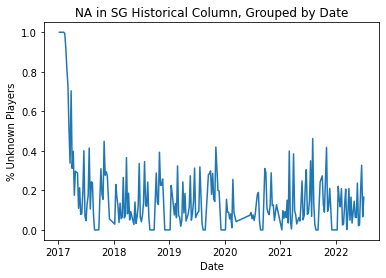

In [112]:
# percentage of unknown players in a tournament
plt.plot(test_combined['event_completed'],test_combined['dg_id_y']/test_combined['dg_id_x'])
plt.xlabel('Date')
plt.ylabel('% Unknown Players')
plt.title('NA in SG Historical Column, Grouped by Date')
plt.show;

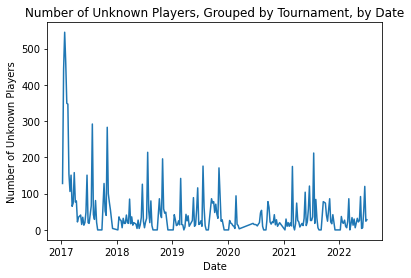

In [113]:
# count of unknown players in a event
UKgrouped = round_level_data_2.groupby('event_completed')['unknownplayer'].sum().reset_index()

plt.plot(UKgrouped['event_completed'],UKgrouped['unknownplayer'])
plt.xlabel('Date')
plt.ylabel('Number of Unknown Players')
plt.title('Number of Unknown Players, Grouped by Tournament, by Date')
plt.show;

So, we can see that it takes awhile to "fill" SG historical data. That was done when the factor was created on purpose. Other than that, there are a few events with decently high amount of players without historical data. 


Nothing out of the ordinary, now the question becomes: should the values be filled, or should these players be dropped? Since we have a binary variable for unknown players, and unknown players are the NA values for this column. So, it is reasonable to fill the value for historical SG metrics with a 0 (not yearly, will not be using for linear model and players without data in these categories will need to be dropped). 

In [114]:
round_level_data_2[['stSG_adjusted','halflifeSG_strength']] = round_level_data_2[['stSG_adjusted','halflifeSG_strength']].fillna(0) 

In [115]:
round_level_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99059 entries, 0 to 99058
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dg_id                  99059 non-null  int64         
 1   player_name            99059 non-null  object        
 2   event_id               99059 non-null  int64         
 3   event_name             99059 non-null  object        
 4   event_completed        99059 non-null  datetime64[ns]
 5   fin_text               99059 non-null  object        
 6   course_name            99059 non-null  object        
 7   course_num             99059 non-null  int64         
 8   course_par             99059 non-null  int64         
 9   score                  99059 non-null  int64         
 10  sg_app                 78573 non-null  float64       
 11  sg_arg                 78573 non-null  float64       
 12  sg_ott                 78573 non-null  float64       
 13  s

**So we have dealt with all the null values that we wanted to get rid of (keep nulls in the SG columns, might need to drop these columns if we use the specific columns as factors)** 

# Adding in Course Information to the Table

Read in the course information:

In [116]:
coursetable = pd.read_csv('dg_course_table (4).csv')
df = coursetable.replace('undefined',np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   course                77 non-null     object 
 1   par                   77 non-null     int64  
 2   yardage               77 non-null     int64  
 3   yardage_4_5           77 non-null     int64  
 4   yardage_3             77 non-null     int64  
 5   adj_score_to_par      77 non-null     float64
 6   adj_par_3_score       77 non-null     float64
 7   adj_par_4_score       77 non-null     float64
 8   adj_par_5_score       77 non-null     float64
 9   adj_driving_distance  77 non-null     float64
 10  adj_sd_distance       77 non-null     float64
 11  adj_driving_accuracy  77 non-null     float64
 12  putt_sg               77 non-null     float64
 13  arg_sg                77 non-null     float64
 14  app_sg                77 non-null     float64
 15  ott_sg                77 

In [117]:
# drop empty columns and non important columns to the classifier problem
df = df.drop(columns=['fw_diff','rgh_diff','non_rgh_diff','adj_penalties','adj_ob'])
df.describe()

,par,yardage,yardage_4_5,yardage_3,adj_score_to_par,adj_par_3_score,adj_par_4_score,adj_par_5_score,adj_driving_distance,adj_sd_distance,...,miss_fw_pen_frac,adj_gir,less_150_sg,greater_150_sg,arg_fairway_sg,arg_rough_sg,arg_bunker_sg,less_5_ft_sg,greater_5_less_15_sg,greater_15_sg
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,71.090909,7211.350649,461.974026,191.181818,0.007403,0.086364,0.060909,-0.317403,287.415584,18.406494,...,0.038819,0.677521,-0.000935,0.003506,-0.008104,-0.000584,-0.003377,0.002104,-0.002325,-0.002130
std,0.861178,193.481861,13.092760,9.624157,1.506658,0.073322,0.083904,0.122307,7.358151,2.054157,...,0.025859,0.059111,0.036377,0.035875,0.029487,0.050021,0.059040,0.004941,0.018678,0.015552
min,70.000000,6802.000000,430.000000,168.000000,-3.230000,-0.050000,-0.090000,-0.660000,270.200000,15.000000,...,0.001300,0.546900,-0.088000,-0.074000,-0.101000,-0.110000,-0.291000,-0.012000,-0.046000,-0.058000
25%,70.000000,7081.000000,453.000000,186.000000,-1.140000,0.040000,-0.010000,-0.400000,282.900000,17.100000,...,0.017900,0.635000,-0.026000,-0.016000,-0.026000,-0.039000,-0.025000,0.000000,-0.014000,-0.011000
50%,71.000000,7248.000000,464.000000,191.000000,0.070000,0.070000,0.050000,-0.300000,286.400000,17.900000,...,0.036300,0.674000,-0.001000,0.003000,-0.001000,0.000000,0.005000,0.002000,-0.001000,0.002000
75%,72.000000,7337.000000,470.000000,197.000000,0.930000,0.130000,0.120000,-0.240000,292.000000,19.400000,...,0.056500,0.722400,0.022000,0.028000,0.013000,0.030000,0.031000,0.005000,0.012000,0.007000
max,73.000000,7671.000000,496.000000,213.000000,4.450000,0.290000,0.290000,-0.090000,304.800000,27.500000,...,0.105100,0.787000,0.088000,0.085000,0.053000,0.126000,0.113000,0.013000,0.040000,0.031000


**Noticing one thing to adjust for, yardage needs to be adjusted to par**

To do this, just divide by the 'par' to get yardage per par. 

In [118]:
df2 = df.copy()

df2['yardage/par'] = df2['yardage']/df2['par']

df2[['course','yardage/par','par','yardage','fw_width']].sort_values('yardage/par').tail(10)

,course,yardage/par,par,yardage,fw_width
32,Olympia Fields CC (North),104.057143,70,7284,26.4
11,Quail Hollow Club,104.352113,71,7409,30.8
10,Congressional CC (Blue),104.450704,71,7416,26.7
19,Firestone CC (South),104.814286,70,7337,23.5
2,Torrey Pines (South),105.236111,72,7577,26.4
3,Quail Hollow Club (PGA Championship),105.464789,71,7488,31.4
12,Winged Foot GC,105.600000,70,7392,31.9
9,Southern Hills Country Club,105.971429,70,7418,44.2
0,Ocean Course at Kiawah Island,106.541667,72,7671,36.7
1,Torrey Pines South (U.S. Open),107.535211,71,7635,28.9


Only able to use columns about the course, the other columns are calculated using tournament averages, so they would cause a form of data leakage possibly (could be worth looking into past tournament averages(?) but this information is using total tournament averages at the course)

In [119]:
df3 = df2[['course','fw_width','yardage','yardage/par','par']].copy()
df3.head(10)

,course,fw_width,yardage,yardage/par,par
0,Ocean Course at Kiawah Island,36.7,7671,106.541667,72
1,Torrey Pines South (U.S. Open),28.9,7635,107.535211,71
2,Torrey Pines (South),26.4,7577,105.236111,72
3,Quail Hollow Club (PGA Championship),31.4,7488,105.464789,71
4,Crooked Stick GC,35.2,7474,103.805556,72
5,Medinah Country Club (No. 3),28.1,7470,103.750000,72
6,Trump National Doral,35.9,7469,103.736111,72
7,Augusta National Golf Club,50.2,7444,103.388889,72
8,Caves Valley Golf Club,33.1,7424,103.111111,72
9,Southern Hills Country Club,44.2,7418,105.971429,70


In [120]:
# get the list of course names present in the actual dataset:
list1 = list(round_level_data_2.course_name.unique())

# get list of course names in this course table:
list2 = list(df3.course.unique())

In [121]:
print('Common course names:')
print([i for i in list1 if i in list2])
print('\n Course names in main dataframe and not course dataframe:')
print([i for i in list1 if i not in list2])
print('\n Course names in course dataframe and not found in main dataframe:')
print([i for i in list2 if i not in list1])

Common course names:
['Plantation Course at Kapalua', 'TPC Scottsdale', 'PGA National (Champion)', 'Club de Golf Chapultepec', 'Innisbrook Resort (Copperhead)', 'Eagle Point Golf Club', 'TPC Sawgrass', 'TPC Four Seasons Resort', 'TPC Southwind', 'TPC River Highlands', 'TPC Potomac at Avenel Farm', 'The Old White TPC', 'TPC Deere Run', 'RTJ Trail (Grand National)', 'Glen Abbey GC', 'Firestone CC (South)', 'Glen Oaks Club', 'TPC Boston', 'Conway Farms GC', 'TPC Summerlin', 'Quail Hollow Club', 'Trinity Forest Golf Club', 'Keene Trace Golf Club', 'Bellerive CC', 'Ridgewood CC', 'Aronimink GC', 'Sea Island GC (Seaside)', 'Waialae Country Club', 'Pebble Beach Golf Links', 'TPC San Antonio (Oaks Course)', 'Harbour Town Golf Links', 'Bethpage Black', 'Colonial Country Club', 'Muirfield Village Golf Club', 'Detroit Golf Club', 'TPC Twin Cities', 'Sedgefield Country Club', 'Liberty National Golf Club', 'Medinah Country Club (No. 3)', 'East Lake Golf Club', 'Country Club of Jackson', 'Golf Club 

So, we need to clean the data and connect the two columns better by creating some values for the courses, while also doing some renaming conventions so the courses match (also, some courses have different names within the DF). 

**Rename values in the course_name column from main round dataframe:**

In [122]:
round_level_data_2.replace({'Waialae CC':'Waialae Country Club',
'Stadium Course': 'Pete Dye Stadium Course',
'Torrey Pines GC (South)':'Torrey Pines(South)',
'Pebble Beach GL':'Pebble Beach Golf Links',
'Riviera CC':'The Riviera Country Club',
'Riviera Country Club':'The Riviera Country Club',
'GC of Houston':'Golf Club of Houston',
'Augusta National GC':'Augusta National Golf Club',
'Harbour Town GL':'Harbour Town Golf Links',
'TPC San Antonio - AT&T Oaks':'TPC San Antonio (Oaks Course)',
'Colonial CC':'Colonial Country Club',
'Muirfield Village GC':'Muirfield Village Golf Club',
'Nine Bridges':'Club at Nine Bridges',
'Quail Hollow-PGA Championship':'Quail Hollow Club (PGA Championship)',
'Sedgefield CC':'Sedgefield Country Club',
'East Lake GC':'East Lake Golf Club',
'Silverado Resort & Spa (North)':'Silverado Resort and Spa North',
'Sea Island Resort (Seaside)':'Sea Island GC (Seaside)',
'Sea Island Resort (Plantation)':'Sea Island GC (Plantation)',
'La Quinta CC':'La Quinta Country Club',
'Torrey Pines GC (North)':'Torrey Pines (North)',
'Spyglass Hill GC':'Spyglass Hill Golf Course',
'El Camaleon GC':'El Camaleon Golf Club',
'Old Greenwood Golf Course at Tahoe Mountain Club':'Tahoe Mt. Club (Old Greenwood)',
'Grand Reserve Golf Club':'Grand Reserve Country Club',
'CC of Jackson':'Country Club of Jackson'},inplace=True)

**Rename some values in the course DF:**

In [123]:
df3.replace({'Bay Hill Club &amp; Lodge':'Bay Hill Club & Lodge',
'Silverado Resort &amp; Spa (North)':'Silverado Resort and Spa North',
'Hamilton Golf &amp; Country Club':'Hamilton Golf & Country Club'},inplace=True)

**Values found for courses without any data in the course dataframe:**

In [124]:
imputations = pd.DataFrame([{'course':'La Quinta Country Club',
 'par':72,
 'yardage': 7060.0,
 'yardage/par': 98.05,
 'fw_width':34.2},
{'course':'Nicklaus Tournament Course',
 'par':72,
 'yardage': 7180.0,
 'yardage/par':99.7,
 'fw_width':34.2},
{'course':'Torrey Pines(South)',
 'par':72,
 'yardage': 7775.0,
 'yardage/par':108,
 'fw_width':34.2},
{'course':'Torrey Pines (North)',
 'par':72,
 'yardage': 7258.0,
 'yardage/par':100.8,
 'fw_width':34.2},
{'course':'Spyglass Hill Golf Course',
 'par':72,
 'yardage': 7041.0,
 'yardage/par':97.79,
 'fw_width':34.2},
{'course':'Coco Beach Golf & CC',
 'par':72,
 'yardage': 7506.0,
 'yardage/par':104.25,
 'fw_width':34.2},
{'course':'Erin Hills',
 'par':72,
 'yardage': 7741.0,
 'yardage/par':107.5,
 'fw_width':34.2},
{'course':'Royal Birkdale GC',
 'par':70,
 'yardage': 7156.0,
 'yardage/par':102.22,
 'fw_width':34.2},
{'course':'TPC Kuala Lumpur',
 'par':72,
 'yardage': 7005.0,
 'yardage/par':97.3,
 'fw_width':34.2},
{'course':'Club at Nine Bridges',
 'par':72,
 'yardage': 7184.0,
 'yardage/par':99.7,
 'fw_width':34.2},
{'course':'Sheshan International GC',
 'par':72,
 'yardage': 7261.0,
 'yardage/par':100.85,
 'fw_width':34.2},
{'course':'El Camaleon Golf Club',
 'par':71,
 'yardage': 7017.0,
 'yardage/par':98.8,
 'fw_width':34.2},
{'course':'Sea Island GC (Plantation)',
 'par':72,
 'yardage': 7060.0,
 'yardage/par':98.1,
 'fw_width':34.2},
{'course':'Albany',
 'par':72,
 'yardage': 7414.0,
 'yardage/par':102.97,
 'fw_width':34.2},
{'course':'Corales Golf Club',
 'par':72,
 'yardage': 7670.0,
 'yardage/par':106.5,
 'fw_width':34.2},
{'course':'Shinnecock Hills GC',
 'par':70,
 'yardage': 7440.0,
 'yardage/par':106.28,
 'fw_width':34.2},
{'course':'Carnoustie GC',
 'par':71,
 'yardage': 7402.0,
 'yardage/par':104.25,
 'fw_width':34.2},
{'course':'Royal Portrush Golf Club',
 'par':71,
 'yardage': 7344.0,
 'yardage/par':103.4,
 'fw_width':34.2},
{'course':'Montreux Golf & Country Club',
 'par':72,
 'yardage': 7472.0,
 'yardage/par':103.77,
 'fw_width':34.2},
{'course':'Accordia Golf Narashino CC',
 'par':70,
 'yardage': 7041.0,
 'yardage/par':100.58,
 'fw_width':34.2},
{'course':'Port Royal Golf Course',
 'par':71,
 'yardage': 6828.0,
 'yardage/par':96.1,
 'fw_width':34.2},
{'course':'Grand Reserve Country Club',
 'par':72,
 'yardage': 7506.0,
 'yardage/par':104.25,
 'fw_width':34.2},
{'course':'Tahoe Mt. Club (Old Greenwood)',
 'par':71,
 'yardage': 7550.0,
 'yardage/par':106.33,
 'fw_width':34.2},
{'course':"Royal St. George's GC",
 'par':70,
 'yardage': 7189.0,
 'yardage/par':102.7,
 'fw_width':34.2},
{'course':"Kasumigaseki Country Club",
 'par':71,
 'yardage': 7447.0,
 'yardage/par':104.9,
 'fw_width':34.2},
{'course':"Monterey Peninsula CC",
 'par':71,
 'yardage': 6957.0,
 'yardage/par':97.9,
 'fw_width':34.2},
{'course':"St. George's G&CC",
 'par':70,
 'yardage': 7006,
 'yardage/par':100.09,
 'fw_width':34.9},
{'course':'The Country Club',
 'par':70,
 'yardage': 7256.0,
 'yardage/par':103.65,
 'fw_width':34.9},])

**Combine the imputed values into the course dataframe:**

In [125]:
df4 = pd.concat([imputations,df3],axis=0,ignore_index=True)

Let's do one last check if there are any no connected values:

In [126]:
list1 = list(round_level_data_2.course_name.unique())
list2 = list(df4.course.unique())
print([i for i in list1 if i not in list2])

[]


# Merge the course data into the main dataframe:

In [127]:
finaldf = round_level_data_2.merge(df4,how='left',left_on='course_name',right_on='course')

In [128]:
finaldf.drop(columns='course',inplace=True)

**Get average score to par for a tournament**

Measure of how hard a course played on a tournament level.

In [129]:
# Groupby event and calculate the average of the players two year SG averages
average_score = finaldf.groupby('event_completed')['score'].mean()
average_score.rename('average_score',inplace=True)
# Merge back onto the main DF
finaldf = finaldf.merge(average_score,left_on='event_completed',right_on='event_completed',how='left')

In [130]:
finaldf['average_score_to_par'] = finaldf['average_score']-round_level_data_2['course_par'].mean()
# drop average score, not as important as score to par
finaldf.drop(columns='average_score',inplace=True)

In [131]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99059 entries, 0 to 99058
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dg_id                  99059 non-null  int64         
 1   player_name            99059 non-null  object        
 2   event_id               99059 non-null  int64         
 3   event_name             99059 non-null  object        
 4   event_completed        99059 non-null  datetime64[ns]
 5   fin_text               99059 non-null  object        
 6   course_name            99059 non-null  object        
 7   course_num             99059 non-null  int64         
 8   course_par             99059 non-null  int64         
 9   score                  99059 non-null  int64         
 10  sg_app                 78573 non-null  float64       
 11  sg_arg                 78573 non-null  float64       
 12  sg_ott                 78573 non-null  float64       
 13  s

### Lets take a look at the final dataset:

In [132]:
finaldf[['event_name','course_name','sg_event_strength','player_name','stSG_adjusted','halflifeSG_strength','prev_round_tournament']].iloc[50000:50007]

,event_name,course_name,sg_event_strength,player_name,stSG_adjusted,halflifeSG_strength,prev_round_tournament
50000,Wyndham Championship,Sedgefield Country Club,0.26443,"Howell III, Charles",1.367710,0.979575,3.455
50001,Wyndham Championship,Sedgefield Country Club,0.26443,"Armour, Ryan",0.347511,0.263379,2.455
50002,Wyndham Championship,Sedgefield Country Club,0.26443,"Svensson, Adam",0.556306,0.089908,7.455
50003,Wyndham Championship,Sedgefield Country Club,0.26443,"Henley, Russell",0.727516,0.468805,4.455
50004,Wyndham Championship,Sedgefield Country Club,0.26443,"Morikawa, Collin",2.221584,2.200139,1.455
50005,Wyndham Championship,Sedgefield Country Club,0.26443,"Stuard, Brian",-0.168382,0.179840,2.455
50006,Wyndham Championship,Sedgefield Country Club,0.26443,"Stallings, Scott",-0.034524,0.153654,4.455


# Save to CSV

In [133]:
finaldf.to_csv('golf_round_data.csv')